## Data Preprocessing

In [284]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sbn

In [285]:
# load data separately without concatenation
df_train = pd.read_csv("dataset/train.csv", sep=",", low_memory=False)
df_test = pd.read_csv("dataset/test.csv", sep=",", low_memory=False)

In [286]:
# dimensions of train dataset
print("#train samples = ", df_train.shape[0])
print("#train features = ", df_train.shape[1])

#train samples =  103904
#train features =  25


In [287]:
# dimensions of test dataset
print("#test samples = ", df_test.shape[0])
print("#test features = ", df_test.shape[1])

#test samples =  25976
#test features =  25


In [288]:
# definition of preprocessor
from scripts.preprocess import DataPreprocessing

dp = DataPreprocessing()
metadata, num_cols, cat_cols = dp.get_metadata(df_train)

print(f"Metadata ==> total: {len(metadata)} \n", metadata)
print("Numerical features: \n", num_cols)
print("Categorical features: \n", cat_cols)

Metadata ==> total: 25 
 Index(['Unnamed: 0', 'id', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')
Numerical features: 
 ['Unnamed: 0', 'id', 'Age', 'Flight Distance', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

In [289]:
# drop columns that are not important
drop_cols = ["Unnamed: 0", "id"]
df_train = df_train.drop(columns=drop_cols)
df_test = df_test.drop(columns=drop_cols)

In [290]:
# zero handling
# if delay is NaN then it is 0 min
for df in [df_train, df_test]:
    df['Arrival Delay in Minutes'] = df['Arrival Delay in Minutes'].fillna(0)
    df['Departure Delay in Minutes'] = df['Departure Delay in Minutes'].fillna(0)

In [291]:
for df in [df_train, df_test]:
    # sum of delays (log of it)
    df['Total Delay Log'] = np.log1p(df['Departure Delay in Minutes'] + df['Arrival Delay in Minutes'])

In [292]:
# features where 0 means "Not Applicable"
service_cols = [
    'Inflight wifi service',
    'Departure/Arrival time convenient',
    'Ease of Online booking',
    'Gate location',
    'Food and drink',
    'Online boarding',
    'Seat comfort',
    'Inflight entertainment',
    'On-board service',
    'Leg room service',
    'Baggage handling',
    'Checkin service',
    'Inflight service',
    'Cleanliness'
]

In [293]:
# creating new columns with _NA for NaN
for col in service_cols:
    for df in [df_train, df_test]:
        df[col + '_NA'] = (df[col] == 0).astype(int)
        df[col] = df[col].replace(0, np.nan)

In [294]:
metadata, num_cols, cat_cols = dp.get_metadata(df_train)

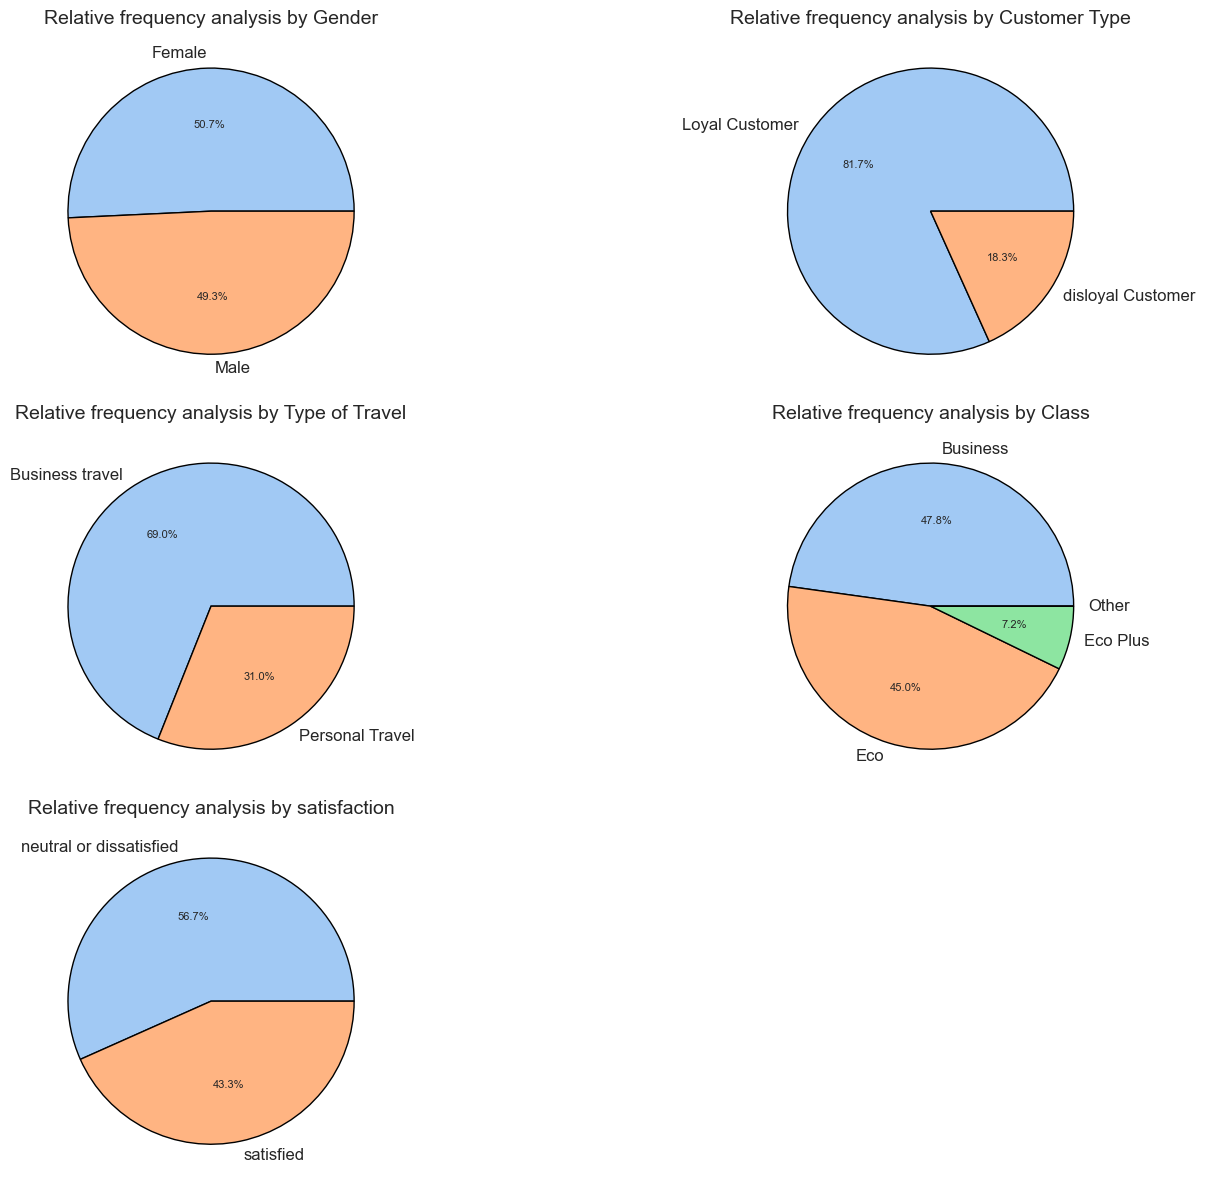

In [295]:
# pie chart to see the distribution
dp.iter_piechart(df_train, list(cat_cols))

   Age  Flight Distance  Inflight wifi service  \
0   13              460                    3.0   
1   25              235                    3.0   
2   26             1142                    2.0   
3   25              562                    2.0   
4   61              214                    3.0   

   Departure/Arrival time convenient  Ease of Online booking  Gate location  \
0                                4.0                     3.0            1.0   
1                                2.0                     3.0            3.0   
2                                2.0                     2.0            2.0   
3                                5.0                     5.0            5.0   
4                                3.0                     3.0            3.0   

   Food and drink  Online boarding  Seat comfort  Inflight entertainment  ...  \
0             5.0              3.0           5.0                     5.0  ...   
1             1.0              3.0           1.0              

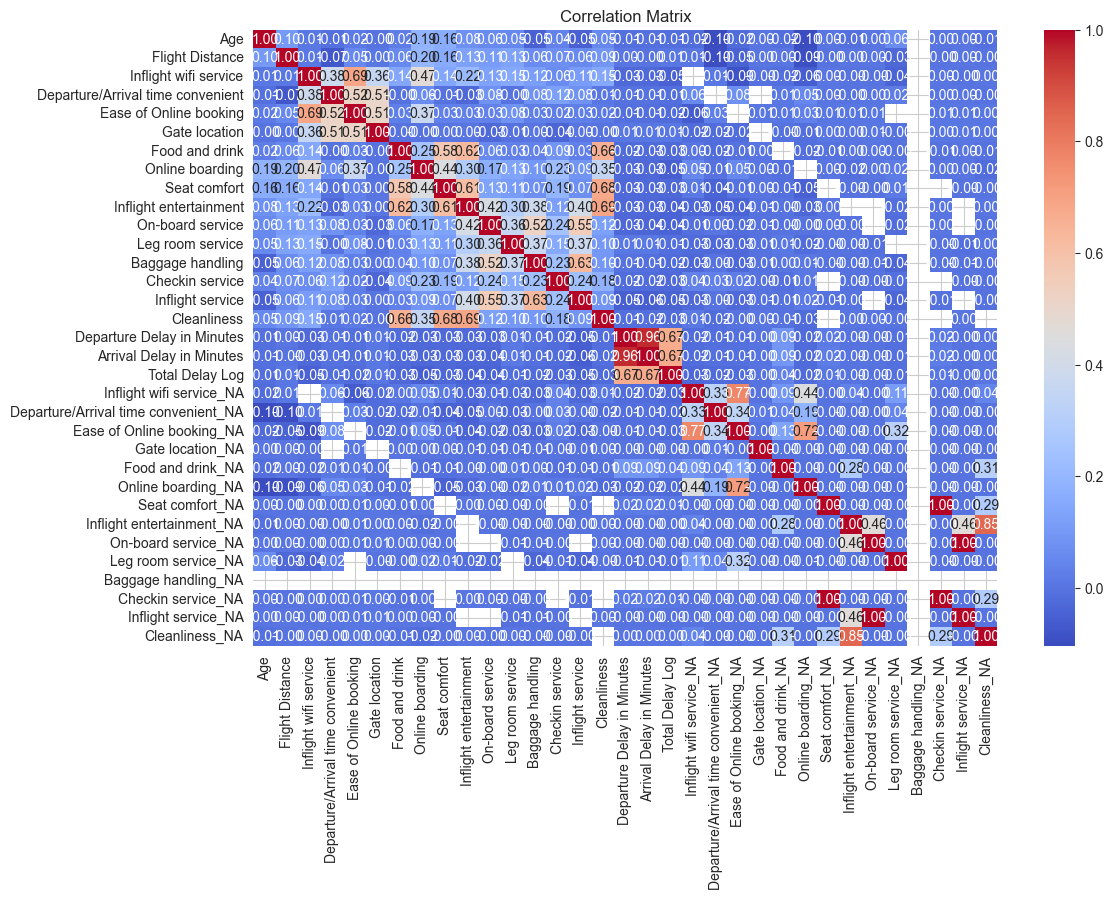

In [296]:
# Select only numeric columns
numeric_data = df_train.select_dtypes(include=['number'])

# Checking Numeric Data
print(numeric_data.head())

# Calculation of the correlation matrix
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(12, 8))
sbn.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [297]:
# removing features with big correlation
for df in [df_train, df_test]:
    df.drop(columns=["Departure Delay in Minutes"], inplace=True)
    df.drop(columns=["Arrival Delay in Minutes"], inplace=True)

## Segment Analysis

Grouping by Type of Travel and Class to know number of people in each segment

In [298]:
segment_stats = df_train.groupby(['Type of Travel', 'Class']).size().reset_index(name='counts')
segment_stats['percentage'] = (segment_stats['counts'] / len(df_train)) * 100

In [299]:
segment_stats

,Type of Travel,Class,counts,percentage
0,Business travel,Business,47508,45.722975
1,Business travel,Eco,20257,19.495881
2,Business travel,Eco Plus,3890,3.743840
3,Personal Travel,Business,2157,2.075955
4,Personal Travel,Eco,26488,25.492763
5,Personal Travel,Eco Plus,3604,3.468586


In [300]:
for index, row in segment_stats.iterrows():
    if row['counts'] < 2000:
        print(f"Segment {row['Type of Travel']} - {row['Class']} too small ({row['counts']} rows).")
    else:
        print(f"Segment {row['Type of Travel']} - {row['Class']} : OK ({row['counts']} rows)")

Segment Business travel - Business : OK (47508 rows)
Segment Business travel - Eco : OK (20257 rows)
Segment Business travel - Eco Plus : OK (3890 rows)
Segment Personal Travel - Business : OK (2157 rows)
Segment Personal Travel - Eco : OK (26488 rows)
Segment Personal Travel - Eco Plus : OK (3604 rows)


## Encoding and Mapping

In [ ]:
# manual mapping of 'Class' to save the order
class_map = {'Eco': 0, 'Eco Plus': 1, 'Business': 2}
for df in [df_train, df_test]:
    df['Class'] = df['Class'].map(class_map)

In [259]:
# other features (Gender, Travel Type, Customer Type)
from sklearn.preprocessing import OrdinalEncoder

categorical_features = ['Gender', 'Type of Travel', 'Customer Type']

oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# train on 'train' and convert 'test'
df_train[categorical_features] = oe.fit_transform(df_train[categorical_features])

# only convert 'test'
df_test[categorical_features] = oe.transform(df_test[categorical_features])

In [260]:
df_train.head(5)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Food and drink_NA,Online boarding_NA,Seat comfort_NA,Inflight entertainment_NA,On-board service_NA,Leg room service_NA,Baggage handling_NA,Checkin service_NA,Inflight service_NA,Cleanliness_NA
0,1.0,0.0,13,1.0,1,460,3,4,3,1,...,0,0,0,0,0,0,0,0,0,0
1,1.0,1.0,25,0.0,2,235,3,2,3,3,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,26,0.0,2,1142,2,2,2,2,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,25,0.0,2,562,2,5,5,5,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0.0,61,0.0,2,214,3,3,3,3,...,0,0,0,0,0,0,0,0,0,0


In [261]:
# making target value 0 and 1
target_map = {'neutral or dissatisfied': 0, 'satisfied': 1}
df_train['satisfaction'] = df_train['satisfaction'].map(target_map)
df_test['satisfaction'] = df_test['satisfaction'].map(target_map)

In [262]:
# split variables
X_train = df_train.drop(columns=['satisfaction'])
y_train = df_train['satisfaction']

X_test = df_test.drop(columns=['satisfaction'])
y_test = df_test['satisfaction']

In [263]:
from sklearn.model_selection import train_test_split

# splitting train on learning (80%) и validation (20%)
X_train_part, X_val, y_train_part, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

In [264]:
print("X-train dim: ", X_train_part.shape)
print("Y-train: ", len(y_train_part))

print("X-test dim: ", X_test.shape)
print("Y-test: ", len(y_test))

print("X-test dim: ", X_val.shape)
print("Y-test: ", len(y_val))

X-train dim:  (83123, 35)
Y-train:  83123
X-test dim:  (25976, 35)
Y-test:  25976
X-test dim:  (20781, 35)
Y-test:  20781


In [265]:
X_train_part

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Food and drink_NA,Online boarding_NA,Seat comfort_NA,Inflight entertainment_NA,On-board service_NA,Leg room service_NA,Baggage handling_NA,Checkin service_NA,Inflight service_NA,Cleanliness_NA
30633,0.0,0.0,47,0.0,2,1521,3,3,3,3,...,0,0,0,0,0,0,0,0,0,0
98857,1.0,1.0,35,0.0,2,2586,3,3,3,4,...,0,0,0,0,0,0,0,0,0,0
80498,0.0,0.0,66,1.0,0,550,2,4,2,2,...,0,0,0,0,0,0,0,0,0,0
73981,1.0,1.0,26,0.0,0,1269,5,4,4,1,...,0,0,0,0,0,0,0,0,0,0
70633,1.0,0.0,48,1.0,0,738,1,5,0,2,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63485,1.0,1.0,36,0.0,2,368,2,2,2,4,...,0,0,0,0,0,0,0,0,0,0
44955,1.0,0.0,46,0.0,2,473,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
53762,1.0,0.0,55,0.0,2,135,5,5,5,5,...,0,0,0,0,0,0,0,0,0,0
32633,1.0,1.0,33,0.0,0,1585,2,2,2,3,...,0,0,0,0,0,0,0,0,0,0


In [266]:
y_train

0         0
1         0
2         1
3         0
4         1
         ..
103899    0
103900    1
103901    0
103902    0
103903    0
Name: satisfaction, Length: 103904, dtype: int64

## Segment Analysis